# Create same model PLIER DelayedPLIER

Let's create a basic PLIER model to compare between the results between PLIER, DelayedPLIER and pyPLIER

# Load libraries/modules

In [8]:
# Load libraries
`%>%` <- dplyr::`%>%`
library(PLIER)
library(dplyr)
library(reticulate)

source(here::here('scripts/plier_util.R'))

out_dir='compare_PLIER_DelayedPLIER_pyPLIER'
dir.create(out_dir, showWarnings=FALSE)

# Load data

In [ ]:
# define output nb
output_nb_path = here('output/nbs/compare_same_model_PLIER_DelayedPLIER')
dir.create(output_nb_path, showWarnings = FALSE)

# Prepare data for all the models

In [6]:
# Assign arguments to variables 
expression_dataset_path <- here::here('output/gtex/GTEx_v8_gene_median_tpm.rds')


# Prepare output directory
output_file_path=dirname(output_file)
dir.create(dirname(output_file_path), showWarnings = FALSE, recursive = TRUE)

# Load PLIER pathway and cell type data
data(bloodCellMarkersIRISDMAP)
data(svmMarkers)
data(canonicalPathways)

# Load data
expression_dataset <- readRDS(expression_dataset_path)

# Remove gene ens id column and duplicate genes
expression_dataset <- subset(expression_dataset, select = -c(gene_ens_id))
expression_dataset <- expression_dataset[!duplicated(expression_dataset["gene_symbol"]),]

# Rename rows with gene symbols
rownames(expression_dataset) <- expression_dataset[,"gene_symbol"]

# Remove gene symbol column
expression_dataset <- subset(expression_dataset, select = -c(gene_symbol))

# Remove NA
expression_dataset = na.omit(expression_dataset)

# Convert to matrix
expression_matrix <- as.matrix(expression_dataset)

# Combine the pathway data from PLIER
all_paths <- PLIER::combinePaths(bloodCellMarkersIRISDMAP, svmMarkers, canonicalPathways)

# What genes are common to the pathway data and the expression matrix
cm_genes <- PLIER::commonRows(all_paths, expression_matrix)

# filter to common genes before row normalization to save on computation
expression_matrix_cm <- expression_matrix[cm_genes, ]

# Z-score normalization
expression_matrix_cm <- PLIER::rowNorm(expression_matrix_cm) 

# Remove NA
expression_matrix_cm=na.omit(expression_matrix_cm)

# What genes are common to the pathway data and the expression matrix
cm_genes <- PLIER::commonRows(all_paths, expression_matrix_cm)

# filter to common genes before row normalization to save on computation
expression_matrix_cm <- expression_matrix_cm[cm_genes, ]
all_paths_cm <- all_paths[cm_genes, ]

# PLIER

## GTEx PLIER preparation

In [26]:
# compute rsvd/svd
set.seed(123456)
ns=ncol(expression_matrix_cm)
message("Computing SVD")
if(ns>500){
  message("Using rsvd")
  set.seed(123456);svdres=rsvd(expression_matrix_cm, k=min(ns, max(200, ns/4)), q=3)
}else{
  svdres=svd(expression_matrix_cm)
}
message("Done")

# save z-scored expression data, the prior information matrix and svdres to be supplied to PLIER::PLIER and the number of PCs

output_file_plier <- file.path(out_dir, 'gtex_comparison_plier.rds')


plier_data_list <- list("expression_matrix_cm" = expression_matrix_cm,
                        "all_paths_cm" = all_paths[cm_genes, ],
                        "svdres" = svdres)

saveRDS(plier_data_list, file = output_file_plier)

Computing SVD

Using rsvd

Done



## GTEx PLIER run

In [28]:
# Assign arguments to variables 
output_file <- file.path(out_dir, 'gtex_comparison_PLIER.rds')
parameter_k <- 1
frac <- 0.7

# Load data
expression_matrix_cm=plier_data_list$expression_matrix_cm
all_paths_cm=plier_data_list$all_paths_cm
svdres=plier_data_list$svdres

# compute k
k=num.pc(svdres)*2
k <- min(k, floor(ncol(expression_matrix_cm)*0.9))
k = k * parameter_k
k = round(k, 0)
message("k is set to ", k)

# Run PLIER (with common genes)
plier_result=PLIER::PLIER(data=expression_matrix_cm, priorMat=all_paths_cm , svdres=svdres, k=k, frac=frac, scale=FALSE)

# Prepare output directory
output_file_path=dirname(output_file)
dir.create(dirname(output_file_path), showWarnings = FALSE, recursive = TRUE)

# Save results
saveRDS(plier_result, file = output_file)

k is set to 1042

Removing 4 pathways with too few genes



[1] 55.53997
[1] "L2 is set to 55.5399692443312"
[1] "L1 is set to 27.7699846221656"


errorY (SVD based:best possible) = 0.6328

New L3 is 0.000804733010124613

New L3 is 0.000710174388842549

New L3 is 0.000710174388842549

New L3 is 0.000804733010124613

New L3 is 0.000804733010124613

New L3 is 0.000804733010124613

New L3 is 0.000911881965554516

New L3 is 0.000911881965554516

New L3 is 0.000911881965554516

New L3 is 0.000911881965554516

New L3 is 0.000911881965554516

New L3 is 0.000911881965554516

New L3 is 0.000911881965554516

New L3 is 0.000911881965554516

New L3 is 0.00103329763864764

New L3 is 0.000911881965554516

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

Bdiff is not decreasing

converged at  iteration 334 Bdiff is not decreasing

There are 216  LVs with AUC>0.70



# DelayedPLIER

In [17]:
output_file_delayedPLIER_hdf5 <- file.path(out_dir, 'counts.hdf5')  
output_file_delayedPLIER_dim <- file.path(out_dir, 'dimnames.RDS') 

writeHDF5Array(expression_matrix_cm, filepath = output_file_delayedPLIER_hdf5, name = "count")
saveRDS(list(row.names = rownames(expression_matrix_cm) , col.names = colnames(expression_matrix_cm)), file = output_file_delayedPLIER_dim)

<6683 x 17382> HDF5Matrix object of type "double":
              [,1]       [,2]       [,3] ...    [,17381]    [,17382]
   [1,]  1.4113228 -0.4424523  0.3365641   . -0.43709630 -0.09997518
   [2,]  5.8423464 -0.7106564  0.7796052   . -0.64629791  1.35986578
   [3,] -0.2272683 -0.5812718 -0.5171569   . -0.59093477 -0.49703849
   [4,]  1.6378622 -0.5300667  0.1609265   . -0.73800558  1.53935231
   [5,]  0.6301441  0.6176855 -0.4076144   .  0.19893678  0.28222509
    ...          .          .          .   .           .           .
[6679,] -0.2462670 -0.7701677 -0.5296683   .  -0.7600938  -0.2738677
[6680,] -0.1980982 -0.2400479 -0.1990823   .  -0.2451261  -0.2109961
[6681,]  2.1421737 -0.7290364  1.5123376   .  -0.9276022   0.7712268
[6682,] -0.6538122 -0.9657483 -0.6224588   .  -1.0976921  -0.7310973
[6683,] -0.7506101 -0.9781575 -0.6702703   .  -0.8675906  -0.6017146

In [118]:
# here::here('scripts/DelayedPLIER_funcs.R')
path_script_funcs = '/home/msubirana/Documents/pivlab/DelayedPLIER/funcs.R' # load from the modified repo!
source(path_script_funcs) #glmnet and HDF5Array will be loaded 
setAutoRealizationBackend("HDF5Array") #supportedRealizationBackends(), getRealizationBackend()

sce <- DelayedArray(seed = HDF5ArraySeed(filepath = output_file_delayedPLIER_hdf5, name = "count"))
dimnamaes <- readRDS(output_file_delayedPLIER_dim)
rownames(sce) <- dimnamaes$row.names
colnames(sce) <- dimnamaes$col.names

sce[is.na(sce)] <- 0
expression_matrix_dp <- sce[which(DelayedMatrixStats::rowSds(sce) >0),]

# Assign arguments to variables 
output_file_delayedPlier <- file.path(out_dir, 'gtex_comparison_delayedPlier.rds')
parameter_k <- 1
frac <- 0.7

# compute k
k=num.pc(svdres)*2
k <- min(k, floor(ncol(expression_matrix_cm)*0.9))
k = k * parameter_k
k = round(k, 0)
message("k is set to ", k)

# Run PLIER (with common genes)
delayedPlier_result=PLIER::PLIER(data=expression_matrix_dp, priorMat=all_paths_cm , svdres=svdres, k=k, frac=frac, scale=FALSE)

# Prepare output directory
output_file_path=dirname(output_file_delayedPlier)
dir.create(dirname(output_file_delayedPlier), showWarnings = FALSE, recursive = TRUE)

# Save results
saveRDS(delayedPlier_result, file = output_file_delayedPlier)

<6683 x 17382> HDF5Matrix object of type "double":
              [,1]       [,2]       [,3] ...    [,17381]    [,17382]
   [1,]  1.4113228 -0.4424523  0.3365641   . -0.43709630 -0.09997518
   [2,]  5.8423464 -0.7106564  0.7796052   . -0.64629791  1.35986578
   [3,] -0.2272683 -0.5812718 -0.5171569   . -0.59093477 -0.49703849
   [4,]  1.6378622 -0.5300667  0.1609265   . -0.73800558  1.53935231
   [5,]  0.6301441  0.6176855 -0.4076144   .  0.19893678  0.28222509
    ...          .          .          .   .           .           .
[6679,] -0.2462670 -0.7701677 -0.5296683   .  -0.7600938  -0.2738677
[6680,] -0.1980982 -0.2400479 -0.1990823   .  -0.2451261  -0.2109961
[6681,]  2.1421737 -0.7290364  1.5123376   .  -0.9276022   0.7712268
[6682,] -0.6538122 -0.9657483 -0.6224588   .  -1.0976921  -0.7310973
[6683,] -0.7506101 -0.9781575 -0.6702703   .  -0.8675906  -0.6017146

k is set to 1042

Removing 4 pathways with too few genes



[1] 55.53997
[1] "L2 is set to 55.5399692443312"
[1] "L1 is set to 27.7699846221656"


ERROR: Error in tcrossprod(x, y): requires numeric/complex matrix/vector arguments


In [107]:
head(expression_matrix_dp)

<6 x 17382> DelayedMatrix object of type "double":
         GTEX-1117F-0226-SM-5GZZ7 ...  GTEX-ZZPU-2726-SM-5NQ8O
GAS6                   1.41132283   .              -0.09997518
MMP14                  5.84234639   .               1.35986578
MARCKSL1              -0.22726833   .              -0.49703849
SPARC                  1.63786217   .               1.53935231
CTSD                   0.63014415   .               0.28222509
EPAS1                 -0.07935625   .               0.68432390

In [108]:
head(all_paths_cm)

,IRIS_Bcell-Memory_IgG_IgA,IRIS_Bcell-Memory_IgM,IRIS_Bcell-naive,IRIS_CD4Tcell-N0,IRIS_CD4Tcell-Th1-restimulated12hour,IRIS_CD4Tcell-Th1-restimulated48hour,IRIS_CD4Tcell-Th2-restimulated12hour,IRIS_CD4Tcell-Th2-restimulated48hour,IRIS_CD8Tcell-N0,IRIS_DendriticCell-Control,⋯,KEGG_GNRH_SIGNALING_PATHWAY,KEGG_BASAL_TRANSCRIPTION_FACTORS,REACTOME_SYNTHESIS_OF_DNA,KEGG_HEMATOPOIETIC_CELL_LINEAGE,KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY,PID_IL4_2PATHWAY,REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR,PID_BCR_5PATHWAY,PID_TELOMERASEPATHWAY,PID_PI3KPLCTRKPATHWAY
GAS6,0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
MMP14,0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
MARCKSL1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
SPARC,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CTSD,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
EPAS1,0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0


In [112]:
# Check the dimensions of your matrices
dim(expression_matrix_dp)
dim(all_paths_cm)

# Check the dimensions of svdres
str(svdres)

[1]  6683 17382

[1] 6683  628

List of 3
 $ d: num [1:4345] 5017 3058 2698 2573 2253 ...
 $ u: num [1:6683, 1:4345] -0.01033 -0.01441 -0.00257 -0.01231 -0.0053 ...
 $ v: num [1:17382, 1:4345] -0.00908 0.00523 -0.00754 -0.00811 0.00894 ...
 - attr(*, "class")= chr "rsvd"


-0.009084249,0.0048984083,0.003729253,-5.068619e-03,-0.001676492,0.0012167764,0.0004521597,-1.731784e-03,0.0028415248,-0.0108770568,⋯,0.010316521,-0.0018216236,0.009547465,0.0007294641,-0.0107351040,-0.003858802,-0.001301917,-0.0065631243,0.015982440,0.0059481690
0.005227597,-0.0006597834,0.007296205,5.113093e-03,0.004106840,0.0058876053,-0.0220267426,1.199124e-02,0.0042095739,-0.0094073135,⋯,0.005766039,0.0031255668,-0.017016444,0.0020608788,0.0178844464,0.010818435,0.008424042,-0.0046739341,-0.006138034,-0.0042348002
-0.007538556,0.0024068316,0.006820188,-6.764531e-03,0.001602638,0.0026827639,-0.0056995087,-3.174828e-03,-0.0118093426,-0.0031382752,⋯,0.008278355,0.0001931016,-0.005094602,0.0028290347,0.0009537677,0.002132480,0.012981176,-0.0209944783,-0.001496447,-0.0032482439
-0.008108760,0.0015281041,0.004592110,-7.836804e-03,0.002823339,0.0022566112,0.0031078898,-1.156762e-04,0.0001972283,-0.0040141988,⋯,-0.012390217,-0.0031648826,0.009541483,0.0027030098,-0.0007984402,-0.012082119,0.010887267,-0.0022341602,-0.004085697,-0.0060873099
0.008938876,0.0006916050,0.004663470,8.402255e-05,0.001085982,0.0026497992,0.0033395725,2.563578e-03,-0.0026726362,-0.0002996245,⋯,-0.006185586,-0.0048198469,0.003343766,-0.0021676098,0.0022386804,0.003489230,0.007948025,-0.0008856395,0.002323073,-0.0007892155
0.002806485,0.0052999336,0.003398989,-3.305127e-03,0.000603851,0.0004749406,0.0070639287,-2.017282e-05,-0.0012545485,-0.0106848200,⋯,0.012219089,0.0194636303,0.011813677,0.0098170893,-0.0210587766,-0.002653762,0.006859786,-0.0036161516,-0.004182263,0.0163174848


In [ ]:
head(delayedPlier_result$Z)

In [ ]:
head(delayedPlier_result$B)

In [5]:
delayed_model = readRDS(file.path(out_dir, 'gtex_comparison_delayedPlier.rds'))
plier_model= readRDS(file.path(out_dir, 'gtex_comparison_PLIER.rds'))

In [15]:
save_directory <- here::here('nbs/10_gtex/compare_PLIER_DelayedPLIER_pyPLIER')

save_as_pickle <- function(object, filename, save_directory) {
  full_path <- file.path(save_directory, filename)
  py_save_object(r_to_py(object), full_path)
}

df_delayed_modelZ <- as.data.frame(delayed_model$Z)
save_as_pickle(df_delayed_modelZ, "delayed_model_Z.pkl", save_directory)

df_plier_modelZ <- as.data.frame(plier_model$Z)
save_as_pickle(df_plier_modelZ, "plier_model_Z.pkl", save_directory)

In [ ]:
# Convert DelayedMatrix object to a regular R matrix
Z_matrix <- as.matrix(delayed_model$Z)

# Convert the R matrix to a Python object
Z_py <- py$dict(Z_matrix)

# Save the Python object as a pickle file
py_pickle <- import("pickle")
with(py_pickle$open("delayed_model_Z.pickle", "wb")) as f:
  py_pickle$dump(Z_py, f)

In [ ]:
plier_model$

In [7]:
head(delayed_model$Z)

<6 x 1042> DelayedMatrix object of type "double":
                [,1]        [,2]        [,3] ...    [,1041]    [,1042]
GAS6     0.274305392 0.087087797 0.675887955   . 0.00000000 0.04389087
MMP14    0.000000000 0.000000000 0.000000000   . 0.00000000 0.00000000
MARCKSL1 0.000000000 0.000000000 0.063091941   . 0.00000000 0.00000000
SPARC    0.000000000 0.000000000 0.633009784   . 0.00000000 0.00000000
CTSD     0.026459878 0.000000000 0.011039844   . 0.00000000 0.00000000
EPAS1    0.000000000 0.009669602 0.078999045   . 0.07326930 0.00000000

In [34]:
dP_B = data.frame(delayed_model$B)
P_B = data.frame(plier_model$B)

dP_Z = data.frame(delayed_model$Z)
P_Z = data.frame(plier_model$Z)

dP_U = data.frame(delayed_model$U)
P_U = data.frame(plier_model$U)

In [35]:
identical(dP_B, P_B)
identical(dP_Z, P_Z)
identical(dP_U, P_U)

[1] FALSE

[1] FALSE

[1] FALSE

In [36]:
dim(dP_B)
dim(P_B)
dim(dP_Z)
dim(P_Z)
dim(dP_U)
dim(P_U)

[1]  1042 17382

[1]  1042 17382

[1] 6683 1042

[1] 6683 1042

[1]  628 1042

[1]  628 1042

In [37]:
head(dP_B)
head(P_B)

,GTEX.1117F.0226.SM.5GZZ7,GTEX.1117F.0426.SM.5EGHI,GTEX.1117F.0526.SM.5EGHJ,GTEX.1117F.0626.SM.5N9CS,GTEX.1117F.0726.SM.5GIEN,GTEX.1117F.1326.SM.5EGHH,GTEX.1117F.2426.SM.5EGGH,GTEX.1117F.2526.SM.5GZY6,GTEX.1117F.2826.SM.5GZXL,GTEX.1117F.2926.SM.5GZYI,⋯,GTEX.ZZPU.1126.SM.5N9CW,GTEX.ZZPU.1226.SM.5N9CK,GTEX.ZZPU.1326.SM.5GZWS,GTEX.ZZPU.1426.SM.5GZZ6,GTEX.ZZPU.1826.SM.5E43L,GTEX.ZZPU.2126.SM.5EGIU,GTEX.ZZPU.2226.SM.5EGIV,GTEX.ZZPU.2426.SM.5E44I,GTEX.ZZPU.2626.SM.5E45Y,GTEX.ZZPU.2726.SM.5NQ8O
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LV 1,0.03453201,-0.02853507,0.069230606,-0.023880816,0.007454924,-0.07349119,-0.04878790,-0.003232558,-0.027628732,0.05111426,⋯,0.02278088,-0.061551059,-0.066891628,-0.0415111099,-0.001698854,-0.013171756,-0.001064865,0.016976576,0.046026835,-0.02232031
"2,IRIS_Neutrophil-Resting",-0.03266857,-0.01827412,0.016805735,0.061387367,-0.007749520,0.19989526,0.01285920,0.001462753,-0.009579407,-0.01911874,⋯,-0.01357981,-0.009514112,0.008975961,0.0007744746,-0.002772309,0.027033518,0.031854593,-0.011890708,-0.029102834,0.04354584
"3,KEGG_REGULATION_OF_ACTIN_CYTOSKELETON",-0.01924855,-0.02274484,0.028675606,0.042876219,0.005564638,-0.05232660,-0.08996938,-0.018993495,-0.018265231,-0.05076361,⋯,0.04230864,-0.032345461,0.006425414,0.0191352475,-0.038697324,-0.029067292,-0.002936913,0.149906950,-0.007922513,-0.03377098
"4,REACTOME_DNA_STRAND_ELONGATION",-0.08761484,0.04436501,-0.083693037,-0.101789962,-0.018988560,-0.09275747,-0.05058139,0.082411057,-0.039415139,-0.04442192,⋯,-0.01180428,-0.075302013,-0.055994696,-0.0237848283,-0.066224722,-0.025659749,0.352255632,-0.070448342,0.034671519,-0.04456839
"5,REACTOME_NEURONAL_SYSTEM",-0.03663372,-0.10461239,-0.005328401,-0.031840078,-0.030117548,-0.02372164,-0.02760613,-0.071462386,-0.042449494,-0.09931509,⋯,-0.03247841,-0.027863043,-0.018518167,-0.0421105986,-0.054427404,-0.007847173,-0.029585970,-0.014998520,-0.042758738,-0.03198667
"6,MIPS_39S_RIBOSOMAL_SUBUNIT_MITOCHONDRIAL",-0.10118090,-0.05437087,-0.128129537,-0.005986193,-0.039431425,-0.05610189,0.05967186,-0.112485449,-0.050376124,-0.04750478,⋯,-0.03618155,0.042053864,-0.018468681,-0.0157586527,-0.002197469,-0.013114171,-0.062146612,-0.008903364,-0.027477639,-0.06155261


,GTEX.1117F.0226.SM.5GZZ7,GTEX.1117F.0426.SM.5EGHI,GTEX.1117F.0526.SM.5EGHJ,GTEX.1117F.0626.SM.5N9CS,GTEX.1117F.0726.SM.5GIEN,GTEX.1117F.1326.SM.5EGHH,GTEX.1117F.2426.SM.5EGGH,GTEX.1117F.2526.SM.5GZY6,GTEX.1117F.2826.SM.5GZXL,GTEX.1117F.2926.SM.5GZYI,⋯,GTEX.ZZPU.1126.SM.5N9CW,GTEX.ZZPU.1226.SM.5N9CK,GTEX.ZZPU.1326.SM.5GZWS,GTEX.ZZPU.1426.SM.5GZZ6,GTEX.ZZPU.1826.SM.5E43L,GTEX.ZZPU.2126.SM.5EGIU,GTEX.ZZPU.2226.SM.5EGIV,GTEX.ZZPU.2426.SM.5E44I,GTEX.ZZPU.2626.SM.5E45Y,GTEX.ZZPU.2726.SM.5NQ8O
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"1,IRIS_Neutrophil-Resting",-0.06466991,-0.05444442,-0.11487165,-0.035270359,-0.016221577,-0.08795147,-0.043152199,-0.02652864,-0.01357084,-0.06115114,⋯,-0.015111653,-0.0081364322,0.01361394,0.0091803918,-0.003859179,-0.01732336,0.008987620,-0.027158754,0.008166765,-0.067802356
"2,IRIS_Neutrophil-Resting",-0.05571578,-0.01590762,0.01577313,0.020790523,-0.008301199,0.08083894,-0.017205464,-0.02094966,0.01108145,-0.01793904,⋯,0.004208666,0.0250979196,0.01624681,0.0136984738,0.025682792,0.02891395,0.033055040,0.016822676,-0.011734695,0.003665061
LV 3,-0.03838166,0.03482423,-0.02717656,0.082874772,0.014864420,-0.03795240,0.067458966,0.05625198,0.02319226,0.04187308,⋯,0.039603366,-0.0131135798,-0.03702630,0.0153230015,-0.048164293,-0.03551308,0.023533739,0.060811821,0.014446735,-0.010462315
"4,REACTOME_DNA_STRAND_ELONGATION",-0.04186157,-0.05852824,-0.08404430,-0.093036016,-0.044522459,-0.10942290,-0.074321773,0.07691609,-0.01977538,-0.05429195,⋯,-0.033256591,-0.0622496509,-0.08244244,-0.0331149318,-0.094837675,-0.01099475,0.350614733,-0.114707087,-0.032924232,-0.059023543
LV 5,-0.06491813,-0.02373363,-0.07026314,-0.002406268,0.014472661,-0.02067548,-0.002451937,-0.01588877,0.01729428,0.01426269,⋯,0.043720364,0.0366697386,0.02405436,0.0005016018,0.003232915,0.02730512,-0.005763948,0.001769326,-0.035416927,-0.016337502
"6,REACTOME_CELL_CYCLE",-0.05129524,-0.04315978,-0.09255232,-0.002334088,-0.055644603,-0.07307825,-0.013328589,-0.08143266,-0.04448419,-0.01763071,⋯,-0.035534652,-0.0002110482,-0.05467570,-0.0218612034,-0.013739038,-0.09074433,-0.033209628,-0.015577431,-0.039951759,-0.028047764


In [38]:
head(dP_Z)
head(P_Z) 

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X1033,X1034,X1035,X1036,X1037,X1038,X1039,X1040,X1041,X1042
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAS6,0.27430539,0.087087797,0.67588796,0.006886257,0,0.039737414,0.0000000,0.1488336980,0.62829993,0.00000000,⋯,0.0000000,0.00000000,0.2081600,0.000000000,0.00000000,0.05558472,0,0.0000000,0.0000000,0.04389087
MMP14,0.00000000,0.000000000,0.00000000,0.059793633,0,0.000000000,0.1319655,0.0885056077,0.79200247,0.05847276,⋯,0.0000000,0.00000000,0.0000000,0.000000000,0.03387982,0.05303867,0,0.0000000,0.0000000,0.00000000
MARCKSL1,0.00000000,0.000000000,0.06309194,0.000000000,0,0.056461721,0.0000000,0.0173531588,0.00569385,0.00000000,⋯,0.1730694,0.00000000,0.0440362,0.004335352,0.00000000,0.00000000,0,0.0000000,0.0000000,0.00000000
SPARC,0.00000000,0.000000000,0.63300978,0.093929050,0,0.006519107,0.0000000,0.0150254065,0.31534125,0.10027196,⋯,0.0000000,0.00000000,0.0000000,0.000000000,0.10756563,0.00000000,0,0.0000000,0.0000000,0.00000000
CTSD,0.02645988,0.000000000,0.01103984,0.095672291,0,0.000000000,0.0000000,0.1255902669,1.51097641,0.00000000,⋯,0.0000000,0.00000000,0.0000000,0.177918538,0.00000000,0.00000000,0,0.1559392,0.0000000,0.00000000
EPAS1,0.00000000,0.009669602,0.07899905,0.000000000,0,0.052201100,0.1557273,0.0005632658,0.22821122,0.06532447,⋯,0.0000000,0.00571755,0.0000000,0.000000000,0.44298536,0.00000000,0,0.0000000,0.0732693,0.00000000


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X1033,X1034,X1035,X1036,X1037,X1038,X1039,X1040,X1041,X1042
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAS6,0.00000000,0,0.8088228,0.00000000,0.00000000,0.022475980,0.00000000,0,0.722732686,0.000000000,⋯,0.00000000,0.01289279,0.0000000,0.00000000,0.00000000,0.000000000,0,0.000000000,0.02679134,0.5149712
MMP14,0.00000000,0,0.0000000,0.03365089,0.04630009,0.000000000,0.00000000,0,0.631639811,0.000000000,⋯,0.00000000,0.08506112,0.1338525,0.00000000,0.00000000,0.000000000,0,0.006647826,0.00000000,0.3673954
MARCKSL1,0.01613378,0,0.0000000,0.00000000,0.06688880,0.066676153,0.00000000,0,0.007572313,0.000000000,⋯,0.09874767,0.00000000,0.0000000,0.00000000,0.00691434,0.008059198,0,0.000000000,0.08562033,0.2394095
SPARC,0.00000000,0,0.2178293,0.05884839,0.00000000,0.000000000,0.00000000,0,0.307728319,0.000000000,⋯,0.00000000,0.00000000,0.0000000,0.02233023,0.00000000,0.000000000,0,0.094854111,0.00000000,0.2220075
CTSD,0.36951508,0,0.4789879,0.11634386,0.00000000,0.004501709,0.00000000,0,1.338231068,0.006038829,⋯,0.00000000,0.02404874,0.0000000,0.00000000,0.03719229,0.000000000,0,0.000000000,0.00000000,0.3540167
EPAS1,0.00000000,0,0.0000000,0.00000000,0.00000000,0.019567018,0.07301501,0,0.139432989,0.000000000,⋯,0.00000000,0.00000000,0.0000000,1.31723287,0.75172429,0.000000000,0,0.100465770,0.00000000,0.1011839


In [39]:
head(dP_U)
head(P_U)

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,⋯,LV1033,LV1034,LV1035,LV1036,LV1037,LV1038,LV1039,LV1040,LV1041,LV1042
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IRIS_Bcell-Memory_IgG_IgA,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-Memory_IgM,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-naive,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-N0,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated12hour,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated48hour,0,0,0,0.1468791,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,⋯,LV1033,LV1034,LV1035,LV1036,LV1037,LV1038,LV1039,LV1040,LV1041,LV1042
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IRIS_Bcell-Memory_IgG_IgA,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-Memory_IgM,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-naive,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-N0,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated12hour,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated48hour,0,0,0,0.1931859,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Correlation

In [43]:
mean(mapply(cor, dP_Z, P_Z))

[1] 0.1948377

In [44]:
mean(mapply(cor, dP_Z, P_Z, method = "spearman"))

[1] 0.1315729

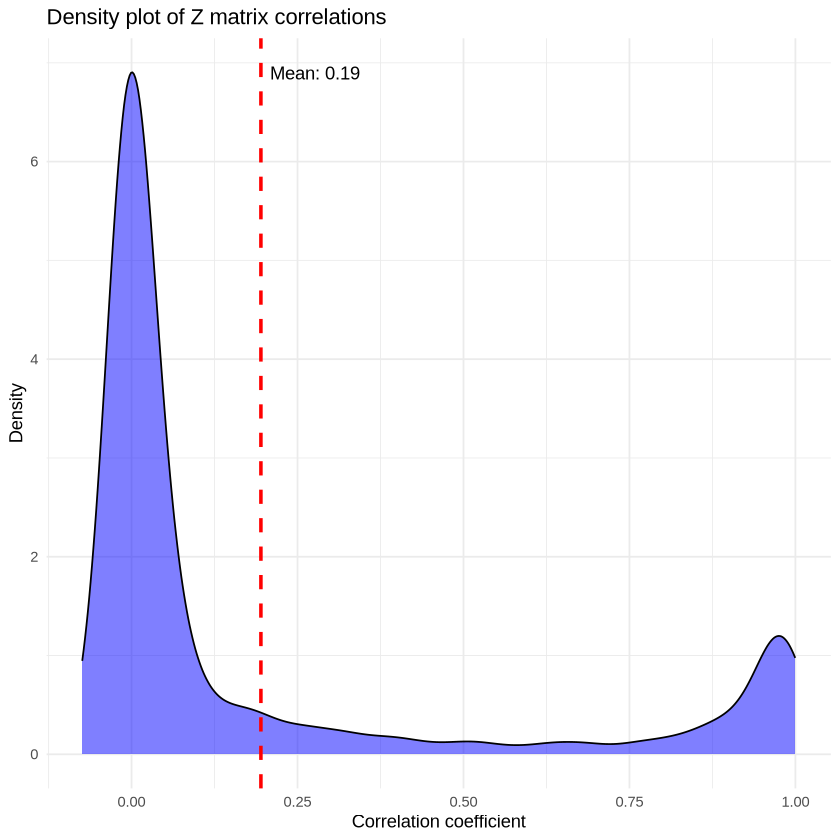

In [52]:
# Assuming matrices dP_Z and P_Z already exist
# Calculate correlations using mapply
correlations <- mapply(cor, dP_Z, P_Z)

# Create a data frame for ggplot
cor_df <- data.frame(Correlations = correlations)

# Calculate the mean of the correlations
mean_correlation <- mean(correlations)

# Plot density of correlations with mean line
ggplot2::ggplot(cor_df, ggplot2::aes(x = Correlations)) + 
    ggplot2::geom_density(fill = "blue", alpha = 0.5) + 
    ggplot2::geom_vline(xintercept = mean_correlation, color = "red", linetype = "dashed", linewidth = 1) +
    ggplot2::labs(title = "Density plot of Z matrix correlations", 
         x = "Correlation coefficient", 
         y = "Density") +
    ggplot2::annotate("text", x = mean_correlation, y = max(density(correlations)$y), label = sprintf("Mean: %.2f", mean_correlation), hjust = -0.1) +
    ggplot2::theme_minimal()


In [87]:
tP_Z = head(P_Z, 100)
tP_Z = tP_Z %>% select(1:100)

tdP_Z = head(dP_Z, 100)
tdP_Z = tdP_Z %>% select(1:100)

colnames(tP_Z) =  paste0('L', 1:ncol(tP_Z))
colnames(tdP_Z) =  paste0('L', 1:ncol(tP_Z))

In [88]:
head(tP_Z)
head(tdP_Z)

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,⋯,L91,L92,L93,L94,L95,L96,L97,L98,L99,L100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAS6,0.00000000,0,0.8088228,0.00000000,0.00000000,0.022475980,0.00000000,0,0.722732686,0.000000000,⋯,0.000000000,0.00000000,0.00000000,0.00000000,0.000000000,0.001802729,0.019407212,0.0000000,0.001965151,0.0000000
MMP14,0.00000000,0,0.0000000,0.03365089,0.04630009,0.000000000,0.00000000,0,0.631639811,0.000000000,⋯,0.000000000,0.02545758,0.00000000,0.05095480,0.002711559,0.000000000,0.000000000,0.0000000,0.037151839,0.0000000
MARCKSL1,0.01613378,0,0.0000000,0.00000000,0.06688880,0.066676153,0.00000000,0,0.007572313,0.000000000,⋯,0.338794934,0.00000000,0.86289964,0.00000000,0.000000000,0.000000000,0.007595633,0.0000000,0.000000000,0.0000000
SPARC,0.00000000,0,0.2178293,0.05884839,0.00000000,0.000000000,0.00000000,0,0.307728319,0.000000000,⋯,0.000000000,0.00000000,0.00000000,0.00000000,0.000000000,0.088283220,0.000000000,0.0000000,0.000000000,0.1688337
CTSD,0.36951508,0,0.4789879,0.11634386,0.00000000,0.004501709,0.00000000,0,1.338231068,0.006038829,⋯,0.000000000,0.23920965,0.01808534,0.00000000,0.016376582,0.059141767,0.111047612,0.0413611,0.000000000,0.0000000
EPAS1,0.00000000,0,0.0000000,0.00000000,0.00000000,0.019567018,0.07301501,0,0.139432989,0.000000000,⋯,0.001651514,0.00000000,0.00000000,0.03237304,0.000000000,0.014972295,0.000000000,0.0000000,0.000000000,0.0000000


,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,⋯,L91,L92,L93,L94,L95,L96,L97,L98,L99,L100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAS6,0.27430539,0.087087797,0.67588796,0.006886257,0,0.039737414,0.0000000,0.1488336980,0.62829993,0.00000000,⋯,0.00000000,0.00000000,0.04457288,0.00000000,0.026319937,0,0.000000000,0.0000000,0.00000000,0.0000000
MMP14,0.00000000,0.000000000,0.00000000,0.059793633,0,0.000000000,0.1319655,0.0885056077,0.79200247,0.05847276,⋯,0.26443426,0.00000000,0.00000000,0.00000000,0.008380394,0,0.000000000,0.0000000,0.00000000,0.0000000
MARCKSL1,0.00000000,0.000000000,0.06309194,0.000000000,0,0.056461721,0.0000000,0.0173531588,0.00569385,0.00000000,⋯,0.25998663,0.02950258,0.32658852,0.02686334,0.000000000,0,0.003674772,0.0000000,0.00000000,0.1471075
SPARC,0.00000000,0.000000000,0.63300978,0.093929050,0,0.006519107,0.0000000,0.0150254065,0.31534125,0.10027196,⋯,0.11881055,0.06506273,0.00000000,0.00000000,0.000000000,0,0.000000000,0.0000000,0.00000000,0.0000000
CTSD,0.02645988,0.000000000,0.01103984,0.095672291,0,0.000000000,0.0000000,0.1255902669,1.51097641,0.00000000,⋯,0.09029419,0.00000000,0.01818306,0.09540547,0.000000000,0,0.086530026,0.0604162,0.00000000,0.2875797
EPAS1,0.00000000,0.009669602,0.07899905,0.000000000,0,0.052201100,0.1557273,0.0005632658,0.22821122,0.06532447,⋯,0.05684948,0.00000000,0.07930204,0.00000000,0.000000000,0,0.000000000,0.0000000,0.01951613,0.0000000


In [91]:
tPtdP_corr = calculate_corr_across_lvs(tP_Z, tdP_Z)
top_tPtdP_corr = get_top_correlations(tPtdP_corr)
head(top_tPtdP_corr)

LV_df1,Max_Correlation,LV_df2
<chr>,<dbl>,<chr>
L1,0.6314903,L56
L10,0.6326794,L10
L100,0.8382457,L7
L11,0.9655482,L11
L12,0.9928196,L12
L13,0.8539612,L13


In [93]:
table(table(top_tPtdP_corr$LV_df2))


 1  2  3  4 
49 16  5  1 

In [95]:
mtP_Z = as.matrix(tP_Z)
mtdP_Z = as.matrix(tdP_Z)

In [97]:
# Ensure `lsa` package is installed for cosine similarity
if (!require("lsa")) install.packages("lsa")
library(lsa)

# Function to compute pairwise cosine similarities between two matrices
pairwise_cosine <- function(mat1, mat2) {
  similarities <- outer(1:ncol(mat1), 1:ncol(mat2), 
                        Vectorize(function(i, j) cosine(mat1[, i], mat2[, j])))
  return(similarities)
}

# Compute cosine similarity between all columns
similarity_matrix <- pairwise_cosine(mtP_Z, mtdP_Z)


# Find the best matching column indices and compute overall similarity
best_matches <- apply(similarity_matrix, 1, max)
mean_similarity <- mean(best_matches)

# Display the similarity score
print(mean_similarity)


[1] 0.7452262


In [ ]:

# Compute correlation matrix between df1 and df2 LVs
cor_matrix <- cor(tP_Z, tdP_Z)

# Function to find the best matching pairs
find_best_matches <- function(cor_matrix) {
  matched_df2 <- rep(NA, nrow(cor_matrix))
  lv_names_df2 <- colnames(cor_matrix)
  
  # Create a vector to keep track of which LVs in df2 have been matched
  used_df2 <- rep(FALSE, ncol(cor_matrix))
  
  for (i in seq_len(nrow(cor_matrix))) {
    row_correlations <- cor_matrix[i, ]
    best_match_idx <- which.max(row_correlations)
    
    while (used_df2[best_match_idx]) {
      # If the best match LV is already used, set its correlation to -Inf
      row_correlations[best_match_idx] <- -Inf
      best_match_idx <- which.max(row_correlations)
    }
    
    # Assign the best match
    matched_df2[i] <- lv_names_df2[best_match_idx]
    used_df2[best_match_idx] = TRUE
  }
  
  matched_df2
}

# Find best matches for df1 LVs in df2
matched_lvs <- find_best_matches(cor_matrix)

# Create a data frame showing which LV in df1 corresponds to which LV in df2
match_result <- data.frame(
  LV_df1 = rownames(cor_matrix),
  LV_df2 = matched_lvs,
  Correlation = mapply(function(x, y) cor_matrix[x, y], rownames(cor_matrix), matched_lvs)
)

# View results
match_result

## PLIER/PLIER vs PLIER/delayedPLIER

In [90]:
calculate_corr_across_lvs= function(df1, df2){

    results_df <- data.frame(LV_df1 = character(), LV_df2 = character(), Correlation = numeric())

    # Nested loop to compare each LV in df1 with each LV in df2
    for (lv1 in names(df1)) {
      for (lv2 in names(df2)) {
        # Calculate the correlation between the current pair of LVs
        correlation <- cor(df1[[lv1]], df2[[lv2]])
        
        # Append the results to the results data frame
        results_df <- rbind(results_df, data.frame(LV_df1 = lv1, LV_df2 = lv2, Correlation = correlation))
      }
    }
    
    return(results_df)
    
}

get_top_correlations = function(results_df){

    top_correlations <- results_df %>%
      group_by(LV_df1) %>%
      summarise(Max_Correlation = max(Correlation),
                LV_df2 = LV_df2[which.max(Correlation)]) %>%
      ungroup()

    return(top_correlations)
        
}

In [53]:
# Initialize an empty data frame to store the results
results_df <- data.frame(LV_df1 = character(), LV_df2 = character(), Correlation = numeric())

# Nested loop to compare each LV in df1 with each LV in df2
for (lv1 in names(dP_Z)) {
  for (lv2 in names(P_Z)) {
    # Calculate the correlation between the current pair of LVs
    correlation <- cor(dP_Z[[lv1]], P_Z[[lv2]])
    
    # Append the results to the results data frame
    results_df <- rbind(results_df, data.frame(LV_df1 = lv1, LV_df2 = lv2, Correlation = correlation))
  }
}

# Print the complete results data frame in a tabular format
print(results_df)


      LV_df1 LV_df2   Correlation
1         X1     X1  1.489498e-01
2         X1     X2  1.352108e-01
3         X1     X3  3.893768e-02
4         X1     X4 -1.850988e-02
5         X1     X5  3.121901e-02
6         X1     X6 -9.927091e-03
7         X1     X7 -5.032066e-02
8         X1     X8  2.175654e-02
9         X1     X9 -2.547574e-02
10        X1    X10  2.249502e-02
11        X1    X11 -3.031144e-03
12        X1    X12  1.224953e-02
13        X1    X13 -2.490991e-02
14        X1    X14 -2.349141e-02
15        X1    X15  2.350174e-02
16        X1    X16 -1.563899e-02
17        X1    X17 -7.568634e-03
18        X1    X18  2.712229e-02
19        X1    X19 -3.399150e-02
20        X1    X20 -6.208269e-03
21        X1    X21 -1.615011e-02
22        X1    X22 -2.022104e-02
23        X1    X23  1.245573e-02
24        X1    X24  2.065178e-02
25        X1    X25 -5.210824e-03
26        X1    X26 -2.092432e-02
27        X1    X27 -2.684532e-02
28        X1    X28 -2.520796e-02
29        X1  

# A tibble: 1,042 × 3
   LV_df1 Max_Correlation LV_df2
   <chr>            <dbl> <chr> 
 1 X1               0.179 X324  
 2 X10              0.444 X10   
 3 X100             0.709 X613  
 4 X1000            0.957 X242  
 5 X1001            0.568 X430  
 6 X1002            0.793 X626  
 7 X1003            0.681 X675  
 8 X1004            0.980 X919  
 9 X1005            0.708 X490  
10 X1006            0.735 X364  
# ℹ 1,032 more rows


[1] 0.7941691

In [ ]:

# Initialize an empty data frame to store the final unique correlations
final_correlations <- data.frame(LV_df1 = character(), LV_df2 = character(), Max_Correlation = numeric())

# Use a while loop to iteratively find the unique highest correlations
while(nrow(top_correlations) > 0) {
  # Select the LV_df1 pair with the highest correlation
  highest <- top_correlations[which.max(top_correlations$Max_Correlation), ]
  final_correlations <- rbind(final_correlations, highest)
  
  # Remove all instances of the selected LV_df2 from top_correlations
  top_correlations <- top_correlations %>%
    filter(LV_df2 != highest$LV_df2)
}

# Print the results with unique highest correlations
print(final_correlations)

# Calculate the mean of the highest correlations
mean_correlation <- mean(final_correlations$Max_Correlation)
print(mean_correlation)

# Check the distribution of LV_df2 to verify that all are unique
table(table(final_correlations$LV_df2))

In [57]:
table(table(top_correlations$LV_df2))


  1   2   3   4   5 
728 136  11   1   1 